<h1> Amazon Apparel Recommendation </h1>



In [5]:
#import all the necessary packages.

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import gridspec
from scipy.sparse import hstack
# import plotly
# import plotly.figure_factory as ff
# from plotly.graph_objs import Scatter, Layout

# plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [6]:
data = pd.read_json('./tops_fashion.json')

In [7]:
print ('Number of data points : ', data.shape[0], \
       'Number of features/variables:', data.shape[1])

Number of data points :  183138 Number of features/variables: 19


In [8]:
data.columns # prints column-names or feature-names.

Index(['asin', 'author', 'availability', 'availability_type', 'brand', 'color',
       'editorial_reivew', 'editorial_review', 'formatted_price',
       'large_image_url', 'manufacturer', 'medium_image_url', 'model',
       'product_type_name', 'publisher', 'reviews', 'sku', 'small_image_url',
       'title'],
      dtype='object')

# Of these 19 features, we will be using only 7 features in this project.
    1. asin  ( Amazon standard identification number)
    2. brand ( brand to which the product belongs to )
    3. color ( Color information of apparel, it can contain many colors as   a value ex: red and black stripes ) 
    4. product_type_name (type of the apperal, ex: SHIRT/TSHIRT )
    5. medium_image_url  ( url of the image )
    6. title (title of the product.)
    7. formatted_price (price of the product)

In [5]:
data = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]

In [9]:
print ('Number of data points : ', data.shape[0], \
       'Number of features:', data.shape[1])
data.head() # prints the top rows in the table.

Number of data points :  183138 Number of features: 19


,asin,author,availability,availability_type,brand,color,editorial_reivew,editorial_review,formatted_price,large_image_url,manufacturer,medium_image_url,model,product_type_name,publisher,reviews,sku,small_image_url,title
0,B016I2TS4W,None,None,None,FNC7C,None,NaN,Minions Como Superheroes Ironman Women's O Nec...,None,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,Minions Como Superheroes Ironman Long Sleeve R...
1,B01N49AI08,None,None,None,FIG Clothing,None,NaN,Sizing runs on the small side. FIG® recommends...,None,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,FIG Clothing Womens Izo Tunic
2,B01JDPCOHO,None,None,None,FIG Clothing,None,NaN,Sizing runs on the small side. FIG® recommends...,None,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,FIG Clothing Womens Won Top
3,B01N19U5H5,None,None,None,Focal18,None,NaN,100% Brand New & Fashion<br> Quantity: 1 Piece...,None,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[True, https://www.amazon.com/reviews/iframe?a...",None,https://images-na.ssl-images-amazon.com/images...,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...
4,B004GSI2OS,None,Usually ships in 6-10 business days,now,FeatherLite,Onyx Black/ Stone,NaN,,$26.26,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,Featherlite Ladies' Long Sleeve Stain Resistan...


### Missing data for various features.

####  Basic stats for the feature: product_type_name

In [10]:
# We have total 72 unique type of product_type_names
print(data['product_type_name'].describe())

# 91.62% (167794/183138) of the products are shirts,


count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object


In [11]:
# names of different product types
print(data['product_type_name'].unique())

['SHIRT' 'SWEATER' 'APPAREL' 'OUTDOOR_RECREATION_PRODUCT'
 'BOOKS_1973_AND_LATER' 'PANTS' 'HAT' 'SPORTING_GOODS' 'DRESS' 'UNDERWEAR'
 'SKIRT' 'OUTERWEAR' 'BRA' 'ACCESSORY' 'ART_SUPPLIES' 'SLEEPWEAR'
 'ORCA_SHIRT' 'HANDBAG' 'PET_SUPPLIES' 'SHOES' 'KITCHEN' 'ADULT_COSTUME'
 'HOME_BED_AND_BATH' 'MISC_OTHER' 'BLAZER' 'HEALTH_PERSONAL_CARE'
 'TOYS_AND_GAMES' 'SWIMWEAR' 'CONSUMER_ELECTRONICS' 'SHORTS' 'HOME'
 'AUTO_PART' 'OFFICE_PRODUCTS' 'ETHNIC_WEAR' 'BEAUTY'
 'INSTRUMENT_PARTS_AND_ACCESSORIES' 'POWERSPORTS_PROTECTIVE_GEAR' 'SHIRTS'
 'ABIS_APPAREL' 'AUTO_ACCESSORY' 'NONAPPARELMISC' 'TOOLS' 'BABY_PRODUCT'
 'SOCKSHOSIERY' 'POWERSPORTS_RIDING_SHIRT' 'EYEWEAR' 'SUIT'
 'OUTDOOR_LIVING' 'POWERSPORTS_RIDING_JACKET' 'HARDWARE' 'SAFETY_SUPPLY'
 'ABIS_DVD' 'VIDEO_DVD' 'GOLF_CLUB' 'MUSIC_POPULAR_VINYL'
 'HOME_FURNITURE_AND_DECOR' 'TABLET_COMPUTER' 'GUILD_ACCESSORIES'
 'ABIS_SPORTS' 'ART_AND_CRAFT_SUPPLY' 'BAG' 'MECHANICAL_COMPONENTS'
 'SOUND_AND_RECORDING_EQUIPMENT' 'COMPUTER_COMPONENT' 'JEWELRY'
 'B

In [12]:
# find the 10 most frequent product_type_names.
product_type_count = Counter(list(data['product_type_name']))
product_type_count.most_common(10)

[('SHIRT', 167794),
 ('APPAREL', 3549),
 ('BOOKS_1973_AND_LATER', 3336),
 ('DRESS', 1584),
 ('SPORTING_GOODS', 1281),
 ('SWEATER', 837),
 ('OUTERWEAR', 796),
 ('OUTDOOR_RECREATION_PRODUCT', 729),
 ('ACCESSORY', 636),
 ('UNDERWEAR', 425)]

####  Basic stats for the feature: brand

In [13]:
# there are 10577 unique brands
print(data['brand'].describe())

# 183138 - 182987 = 151 missing values.

count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object


In [14]:
brand_count = Counter(list(data['brand']))
brand_count.most_common(10)

[('Zago', 223),
 ('XQS', 222),
 ('Yayun', 215),
 ('YUNY', 198),
 ('XiaoTianXin-women clothes', 193),
 ('Generic', 192),
 ('Boohoo', 190),
 ('Alion', 188),
 ('Abetteric', 187),
 ('TheMogan', 187)]

####  Basic stats for the feature: color

In [15]:

print(data['color'].describe())


# we have 7380 unique colors
# 7.2% of products are black in color
# 64956 of 183138 products have brand information. That's approx 35.4%.

count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object


In [16]:
color_count = Counter(list(data['color']))
color_count.most_common(10)

[(None, 118182),
 ('Black', 13207),
 ('White', 8616),
 ('Blue', 3570),
 ('Red', 2289),
 ('Pink', 1842),
 ('Grey', 1499),
 ('*', 1388),
 ('Green', 1258),
 ('Multi', 1203)]

####  Basic stats for the feature: formatted_price

In [17]:
 
print(data['formatted_price'].describe())

# Only 28,395 (15.5% of whole data) products with price information

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object


In [18]:
price_count = Counter(list(data['formatted_price']))
price_count.most_common(10)

[(None, 154743),
 ('$19.99', 945),
 ('$9.99', 749),
 ('$9.50', 601),
 ('$14.99', 472),
 ('$7.50', 463),
 ('$24.99', 414),
 ('$29.99', 370),
 ('$8.99', 343),
 ('$9.01', 336)]

#### Basic stats for the feature: title


In [19]:
print(data['title'].describe())

# All of the products have a title. 
# Titles are fairly descriptive of what the product is. 
# We use titles extensively in this project 
# as they are short and informative.


count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object


In [22]:
data.to_pickle('pickels/180k_apparel_data')

   We save data files at every major step in our processing in "pickle" files. If you are stuck anywhere (or) if some code takes too long to run on your laptop, you may use the pickle files we give you to speed things up.

In [23]:
# consider products which have price information
# data['formatted_price'].isnull() => gives the information 
#about the dataframe row's which have null values price == None|Null
data = data.loc[~data['formatted_price'].isnull()]
print('Number of data points After eliminating price=NULL :', data.shape[0])

Number of data points After eliminating price=NULL : 28395


In [24]:
# consider products which have color information
# data['color'].isnull() => gives the information about the dataframe row's which have null values price == None|Null
data =data.loc[~data['color'].isnull()]
print('Number of data points After eliminating color=NULL :', data.shape[0])

Number of data points After eliminating color=NULL : 28385


#### We brought down the number of data points from 183K  to 28K.



In [25]:
data.to_pickle('pickels/28k_apparel_data')

In [26]:
#download all these 28k images using this code below.

from PIL import Image
import requests
from io import BytesIO

for index, row in data.iterrows():
        url = row['medium_image_url']
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        img.save('images/28k_images/'+row['asin']+'.jpeg')

"\nfrom PIL import Image\nimport requests\nfrom io import BytesIO\n\nfor index, row in images.iterrows():\n        url = row['large_image_url']\n        response = requests.get(url)\n        img = Image.open(BytesIO(response.content))\n        img.save('images/28k_images/'+row['asin']+'.jpeg')\n\n\n"

### Remove near duplicate items

#### Understand about duplicates.

In [22]:
# read data from pickle file from previous stage
data = pd.read_pickle('pickels/28k_apparel_data')

# find number of products that have duplicate titles.
print(sum(data.duplicated('title')))
# we have 2325 products which have same title but different color


2325


#### In our data there are many duplicate products, we need to de-dupe them for better results.


#### Remove duplicates : Part 1

In [27]:
# read data from pickle file from previous stage
data = pd.read_pickle('pickels/28k_apparel_data')

In [28]:
data.head()

,asin,author,availability,availability_type,brand,color,editorial_reivew,editorial_review,formatted_price,large_image_url,manufacturer,medium_image_url,model,product_type_name,publisher,reviews,sku,small_image_url,title
4,B004GSI2OS,None,Usually ships in 6-10 business days,now,FeatherLite,Onyx Black/ Stone,NaN,,$26.26,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,Featherlite Ladies' Long Sleeve Stain Resistan...
6,B012YX2ZPI,None,Usually ships in 4-5 business days,now,HX-Kingdom Fashion T-shirts,White,NaN,This Personalized Special Olympics World Games...,$9.99,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,Women's Unique 100% Cotton T - Special Olympic...
11,B001LOUGE4,None,None,None,Fitness Etc.,Black,NaN,Light Weight 2x1 Boy Beater Tank Top. Great t...,$11.99,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,Ladies Cotton Tank 2x1 Ribbed Tank Top
15,B003BSRPB0,None,Usually ships in 6-10 business days,now,FeatherLite,White,NaN,FeatherLite Ladies' Moisture Free Mesh Sport S...,$20.54,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",HT-2001_Lime-1149-XL,https://images-na.ssl-images-amazon.com/images...,FeatherLite Ladies' Moisture Free Mesh Sport S...
21,B014ICEDNA,None,Usually ships in 4-5 business days,now,FNC7C,Purple,NaN,Supernatural Chibis Sam Dean And Castiel Women...,$7.50,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[True, https://www.amazon.com/reviews/iframe?a...",None,https://images-na.ssl-images-amazon.com/images...,Supernatural Chibis Sam Dean And Castiel Short...


In [29]:
# Remove All products with very few words in title
data_sorted = data[data['title'].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description:", data_sorted.shape[0])

After removal of products with short description: 27949


In [30]:
# Sort the whole data based on title (alphabetical order of title) 
data_sorted.sort_values('title',inplace=True, ascending=False)
data_sorted.head()

,asin,author,availability,availability_type,brand,color,editorial_reivew,editorial_review,formatted_price,large_image_url,manufacturer,medium_image_url,model,product_type_name,publisher,reviews,sku,small_image_url,title
61973,B06Y1KZ2WB,None,Usually ships in 1-2 business days,now,Éclair,Black/Pink,"Perfect for summer adventures, feminine touch ...",NaN,$24.99,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,Éclair Women's Printed Thin Strap Blouse Black...
133820,B010RV33VE,None,Usually ships in 4-5 business days,now,xiaoming,Pink,<p>Korean Style Womens' Sleeveless Loose Long ...,NaN,$18.19,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,xiaona10326758,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,xiaoming Womens Sleeveless Loose Long T-shirts...
81461,B01DDSDLNS,None,Usually ships in 4-5 business days,now,xiaoming,White,<br>1.xiaoming is a modern lifestyle brand tha...,NaN,$21.58,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,MxiaoCotds,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,xiaoming Women's White Long Sleeve Single Brea...
75995,B00X5LYO9Y,None,Usually ships in 4-5 business days,now,xiaoming,Red Anchors,Sleeve Style: Short Sleeve<br />Patten:Stripes...,NaN,$15.91,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,xiaoming Stripes Tank Patch/Bear Sleeve Anchor...
151570,B00WPJG35K,None,Usually ships in 4-5 business days,now,xiaoming,White,Material :Lace<br />This cardigan is imported ...,NaN,$14.32,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,xiaoming Sleeve Sheer Loose Tassel Kimono Woma...


#### Some examples of dupliacte titles that differ only in the last few words.

<pre>
Titles 1:
16. woman's place is in the house and the senate shirts for Womens XXL White
17. woman's place is in the house and the senate shirts for Womens M Grey

Title 2:
25. tokidoki The Queen of Diamonds Women's Shirt X-Large
26. tokidoki The Queen of Diamonds Women's Shirt Small
27. tokidoki The Queen of Diamonds Women's Shirt Large

Title 3:
61. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
62. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
63. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
64. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
</pre>

In [31]:
indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)

In [33]:
import itertools
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]
while i < num_data_points and j < num_data_points:
    
    previous_i = i

    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    a = data['title'].loc[indices[i]].split()

    # search for the similar products sequentially 
    j = i+1
    while j < num_data_points:

        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'Small']
        b = data['title'].loc[indices[j]].split()

        # store the maximum length of two strings
        length = max(len(a), len(b))

        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1

        # if the number of words in which both strings differ are > 2 , we are considering it as those two apperals are different
        # if the number of words in which both strings differ are < 2 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) > 2: # number of words in which both sensences differ
            # if both strings are differ by more than 2 words we include the 1st string index
            stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])

            # if the comaprision between is between num_data_points, num_data_points-1 strings and they differ in more than 2 words we include both
            if j == num_data_points-1: stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[j]])

            # start searching for similar apperals corresponds 2nd string
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

In [34]:
data = data.loc[data['asin'].isin(stage1_dedupe_asins)]

#### We removed  the dupliactes which differ only at the end.

In [35]:
print('Number of data points : ', data.shape[0])

Number of data points :  17593


In [31]:
data.to_pickle('pickels/17k_apperal_data')

#### Remove duplicates : Part 2

<pre>

In the previous cell, we sorted whole data in alphabetical order of  titles.Then, we removed titles which are adjacent and very similar title

But there are some products whose titles are not adjacent but very similar.

Examples:

Titles-1
86261.  UltraClub Women's Classic Wrinkle-Free Long Sleeve Oxford Shirt, Pink, XX-Large
115042. UltraClub Ladies Classic Wrinkle-Free Long-Sleeve Oxford Light Blue XXL

TItles-2
75004.  EVALY Women's Cool University Of UTAH 3/4 Sleeve Raglan Tee
109225. EVALY Women's Unique University Of UTAH 3/4 Sleeve Raglan Tees
120832. EVALY Women's New University Of UTAH 3/4-Sleeve Raglan Tshirt

</pre>

In [32]:
data = pd.read_pickle('pickels/17k_apperal_data')

In [0]:
# This code snippet takes significant amount of time.
# O(n^2) time.
# Takes about an hour to run on a decent computer.

indices = []
for i,row in data.iterrows():
    indices.append(i)

stage2_dedupe_asins = []
while len(indices)!=0:
    i = indices.pop()
    stage2_dedupe_asins.append(data['asin'].loc[i])
    # consider the first apperal's title
    a = data['title'].loc[i].split()
    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    for j in indices:
        
        b = data['title'].loc[j].split()
        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
        
        length = max(len(a),len(b))
        
        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0]==k[1]):
                count += 1

        # if the number of words in which both strings differ are < 3 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) < 3:
            indices.remove(j)

In [0]:
# from whole previous products we will consider only 
# the products that are found in previous cell 
data = data.loc[data['asin'].isin(stage2_dedupe_asins)]

In [0]:
print('Number of data points after stage two of dedupe: ',data.shape[0])
# from 17k apperals we reduced to 16k apperals

Number of data points after stage two of dedupe:  16042


In [0]:
data.to_pickle('pickels/16k_apperal_data')

# Text pre-processing

In [37]:
data = pd.read_pickle('pickels/16k_apperal_data')

In [38]:
# we use the list of stop words that are downloaded from nltk lib.
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

list of stop words: {'same', 'you', 'their', 'we', 'hers', "couldn't", 'has', 'a', 'i', 'under', 'too', 'in', 'out', 'isn', "doesn't", 'needn', 'for', 'didn', 'own', 'other', 'what', 'these', 'don', 'when', 't', 'against', 'having', 'me', 'an', 'y', 'hasn', 'during', 'here', 'or', 'again', "hasn't", 'only', "you're", "she's", 'they', 'wasn', 'there', 'mustn', 'will', 'being', "aren't", 'now', 'nor', "needn't", 'her', 'weren', 'any', 'my', 'm', 'do', 'ma', 'until', 'very', 'he', 'more', "hadn't", 'haven', 'won', 'them', 'yours', 'further', 'yourselves', 'to', 'she', 'over', 'such', 'while', 'on', "weren't", 'just', 'it', 'itself', 'that', 'shouldn', "shouldn't", 'with', 'both', "you'd", 'is', 'are', 'himself', 'of', 'no', 'below', 'by', 'herself', "don't", 'him', 'from', 'and', 'the', 'above', 'hadn', 'theirs', 'then', "should've", 'about', 'whom', 'should', 'as', 'wouldn', 'aren', "isn't", 'had', 'been', 'have', 'so', 'be', 'd', 'ain', 'at', "that'll", 'couldn', "wasn't", 'mightn', 'yo

In [39]:
start_time = time.clock()
# we take each title and we text-preprocess it.
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')
# we print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")

10.63991110000643 seconds


In [40]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
43,B0079BMKDS,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,APPAREL,featherlite ladies silky smooth pique white xl,$13.53


In [41]:
data.to_pickle('pickels/16k_apperal_data_preprocessed')

## Stemming 

In [38]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
print(stemmer.stem('arguing'))
print(stemmer.stem('fishing'))

argu
fish


# Text based product similarity

In [42]:
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
43,B0079BMKDS,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,APPAREL,featherlite ladies silky smooth pique white xl,$13.53


In [44]:
# Utility Functions which we will use through the rest of the project


#Display an image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)
  
#plotting code to understand the algorithm's decision.
def plot_heatmap(keys, values, labels, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        # url : apparel's url

        # we will devide the whole figure into two parts
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        # 1st, ploting heat map that represents the count of commonly ocurred words in title2
        ax = plt.subplot(gs[0])
        # it displays a cell in white color if the word is intersection(lis of words of title1 and list of words of title2), in black if not
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # apparel title
        
        # 2nd, plotting image of the the apparel
        ax = plt.subplot(gs[1])
        # we don't want any grid lines for image and no labels on x-axis and y-axis
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # we call dispaly_img based with paramete url
        display_img(url, ax, fig)
        
        # displays combine figure ( heat map and image together)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models, 
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf

    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys()) 

    # we set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0 
    values = [vec2[x] for x in vec2.keys()]
    
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)


# this function gets a list of wrods along with the frequency of each 
# word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

## Bag of Words (BoW) on product titles.

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['title'])
title_features.get_shape() # get number of rows and columns in feature matrix.
# title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(corpus) returns 
# the a sparase matrix of dimensions #data_points * #words_in_corpus

# What is a sparse vector?

# title_features[doc_id, index_of_word_in_corpus] = number of times the word occured in that doc

(17593, 12927)

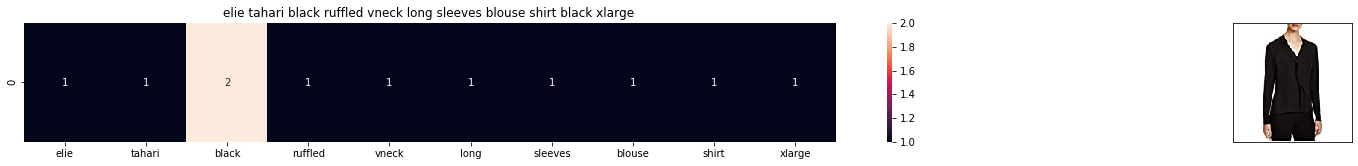

ASIN : B0728DT431
Brand: Elie Tahari
Title: elie tahari black ruffled vneck long sleeves blouse shirt black xlarge 
Euclidean similarity with the query image : 0.0


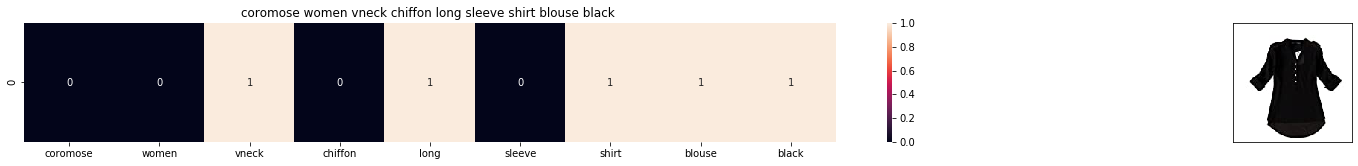

ASIN : B00NNFP22K
Brand: coromose
Title: coromose women vneck chiffon long sleeve shirt blouse black 
Euclidean similarity with the query image : 3.1622776601683795


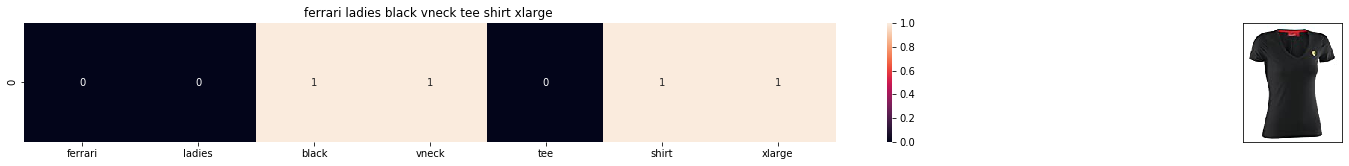

ASIN : B01EZ6XKR4
Brand: Ferrari
Title: ferrari ladies black vneck tee shirt xlarge 
Euclidean similarity with the query image : 3.1622776601683795


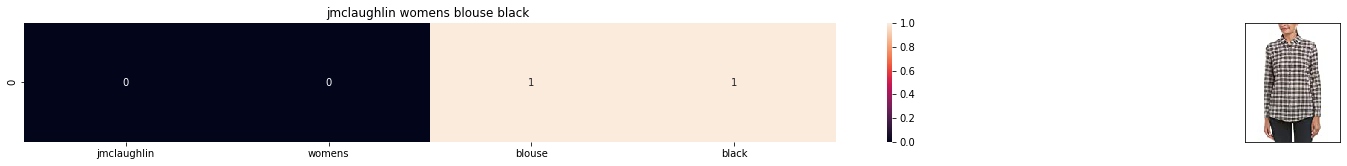

ASIN : B074KN55WS
Brand: J. McLaughlin
Title: jmclaughlin womens blouse black 
Euclidean similarity with the query image : 3.3166247903554


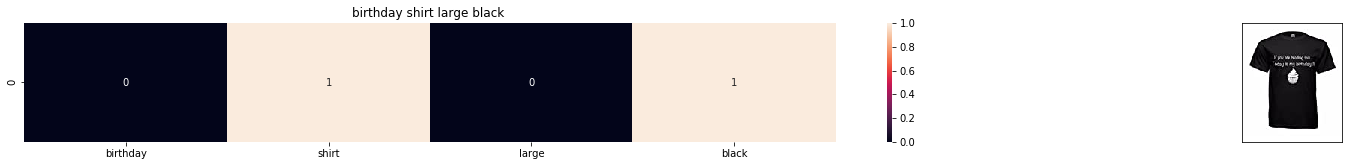

ASIN : B06XQ5V17Z
Brand: Speak Your Piece
Title: birthday shirt large black 
Euclidean similarity with the query image : 3.3166247903554


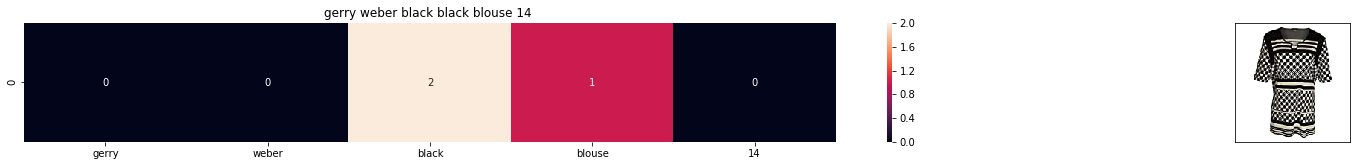

ASIN : B00O492QMI
Brand: Gerry Webber
Title: gerry weber black black blouse 14 
Euclidean similarity with the query image : 3.3166247903554


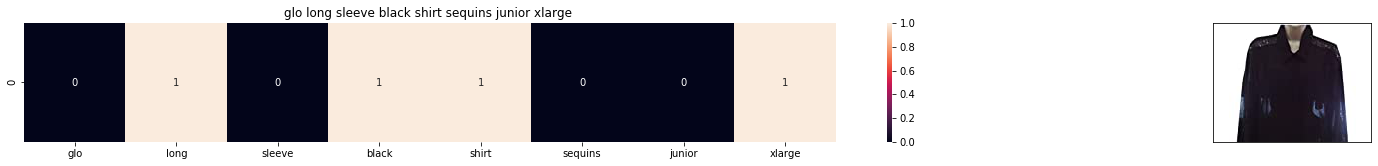

ASIN : B01NBLNC7J
Brand: Glo
Title: glo long sleeve black shirt sequins junior xlarge 
Euclidean similarity with the query image : 3.3166247903554


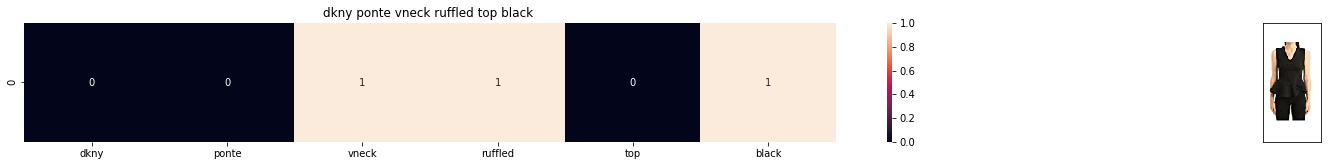

ASIN : B06XH7HQ2T
Brand: DKNY
Title: dkny ponte vneck ruffled top black 
Euclidean similarity with the query image : 3.3166247903554


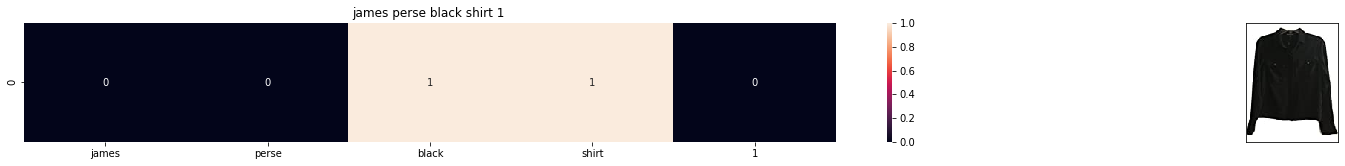

ASIN : B01N8Z2K60
Brand: James Perse
Title: james perse black shirt 1 
Euclidean similarity with the query image : 3.3166247903554


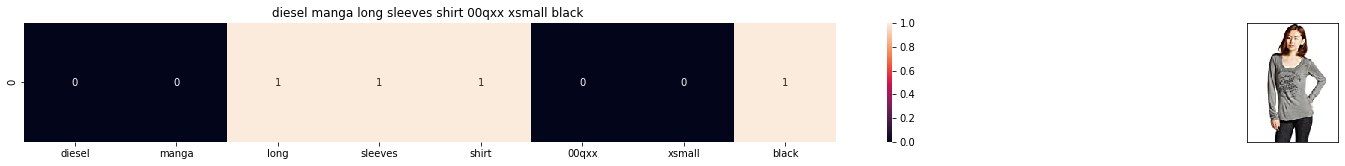

ASIN : B00N2FKJR4
Brand: DIESEL
Title: diesel manga long sleeves shirt 00qxx xsmall black 
Euclidean similarity with the query image : 3.3166247903554


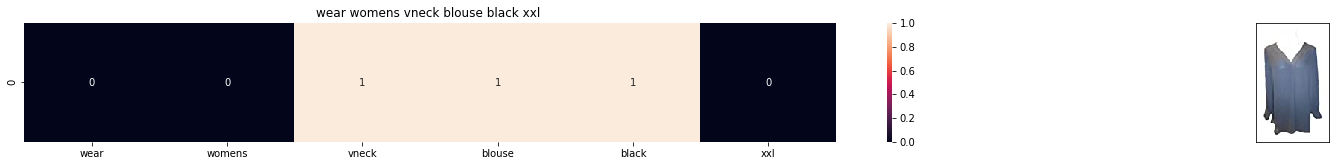

ASIN : B06Y6FH453
Brand: Who What Wear
Title: wear womens vneck blouse black xxl 
Euclidean similarity with the query image : 3.3166247903554


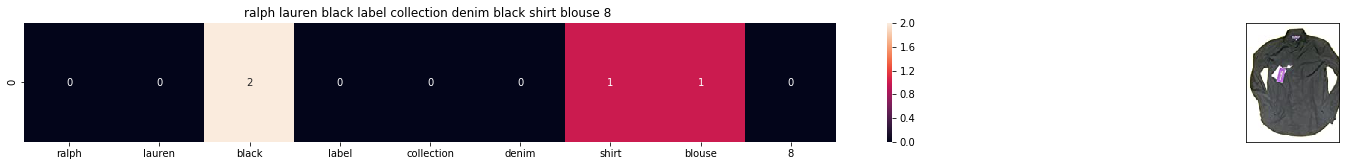

ASIN : B01EUK0EDS
Brand: Ralph Lauren Black Label
Title: ralph lauren black label collection denim black shirt blouse 8 
Euclidean similarity with the query image : 3.4641016151377544


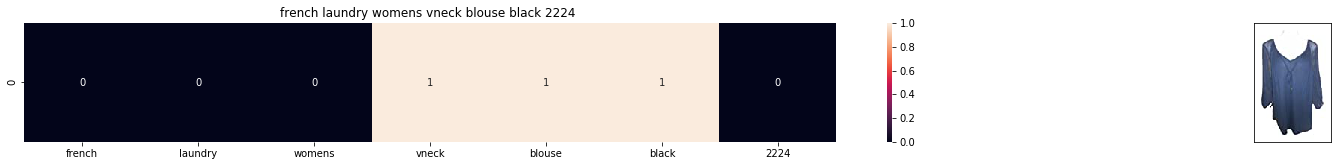

ASIN : B071Y37JDS
Brand: French Laundry
Title: french laundry womens vneck blouse black 2224 
Euclidean similarity with the query image : 3.4641016151377544


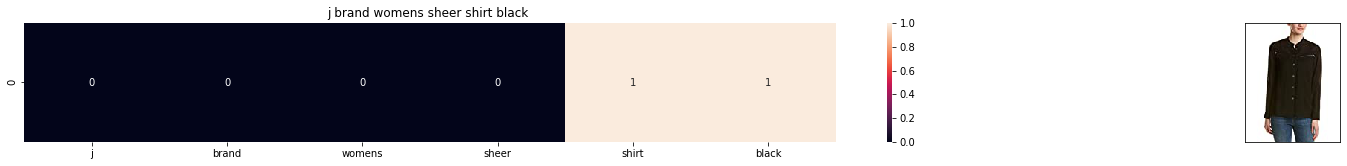

ASIN : B013L1V8PK
Brand: J Brand Jeans
Title: j brand womens sheer shirt black 
Euclidean similarity with the query image : 3.4641016151377544


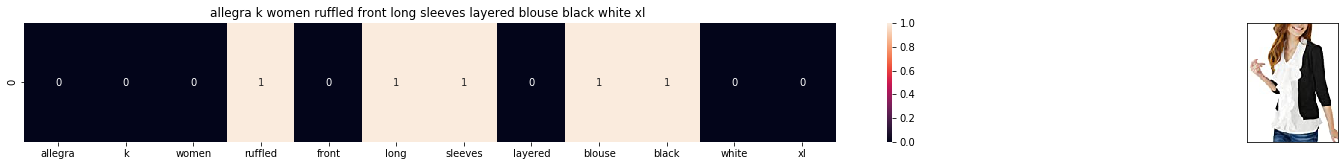

ASIN : B00E1LCYZI
Brand: Allegra K
Title: allegra k women ruffled front long sleeves layered blouse black white xl 
Euclidean similarity with the query image : 3.4641016151377544


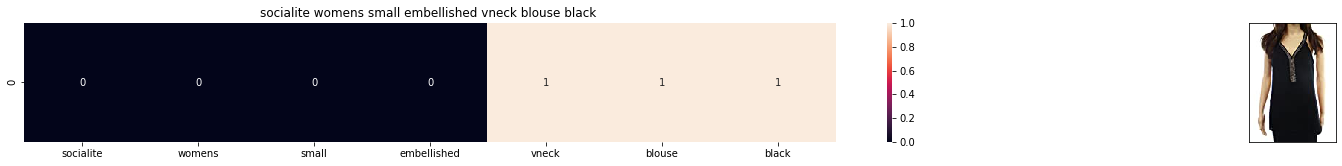

ASIN : B01K11JE9A
Brand: Socialite
Title: socialite womens small embellished vneck blouse black 
Euclidean similarity with the query image : 3.4641016151377544


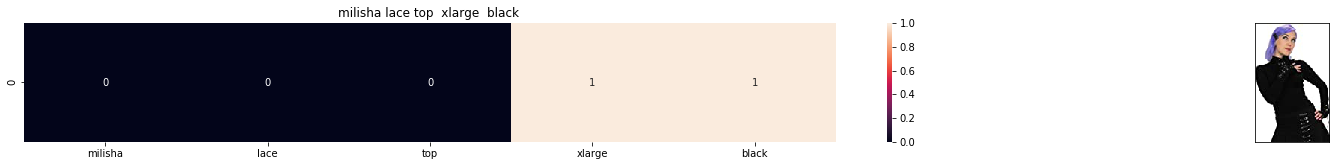

ASIN : B005AFD9WQ
Brand: Milisha
Title: milisha lace top  xlarge  black 
Euclidean similarity with the query image : 3.4641016151377544


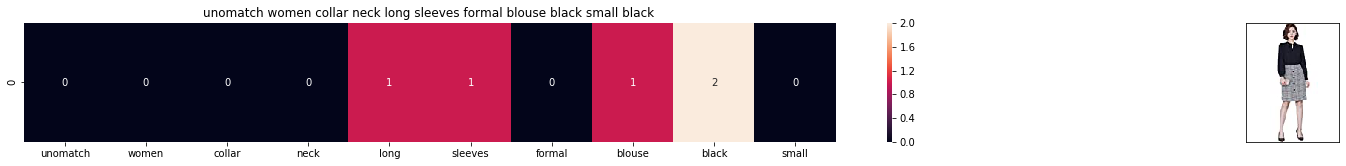

ASIN : B01N9N5VSP
Brand: Unomatch
Title: unomatch women collar neck long sleeves formal blouse black small black 
Euclidean similarity with the query image : 3.4641016151377544


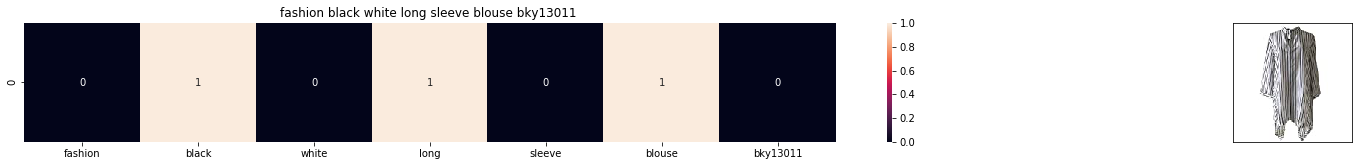

ASIN : B01FO7EI0G
Brand: bankhunyabangyai store
Title: fashion black white long sleeve blouse bky13011 
Euclidean similarity with the query image : 3.4641016151377544


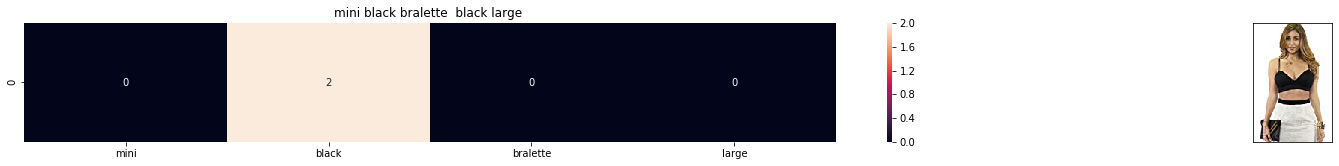

ASIN : B01HT0QG42
Brand: Lushfox
Title: mini black bralette  black large 
Euclidean similarity with the query image : 3.4641016151377544


In [46]:
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances

def bag_of_words_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    
    # np.argsort will return indices of the smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)

#call the bag-of-words model for a product to get similar products.
bag_of_words_model(12566, 20) 
# In the output heat map each value represents the count value 
# of the label word, the color represents the intersection 
# with inputs title.



## TF-IDF based product similarity

In [52]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])
# tfidf_title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(courpus) returns the a sparase matrix of dimensions #data_points * #words_in_corpus
# tfidf_title_features[doc_id, index_of_word_in_corpus] = tfidf values of the word in given doc

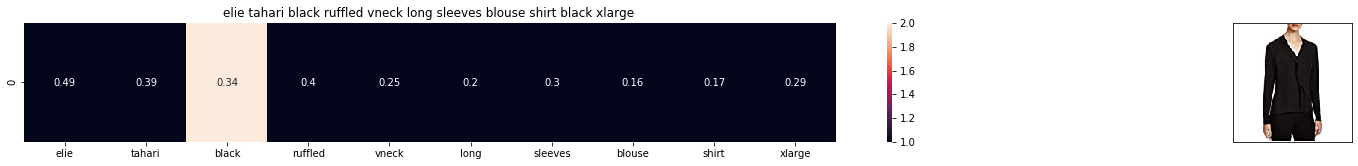

ASIN : B0728DT431
BRAND : Elie Tahari
Eucliden distance from the given image : 0.0


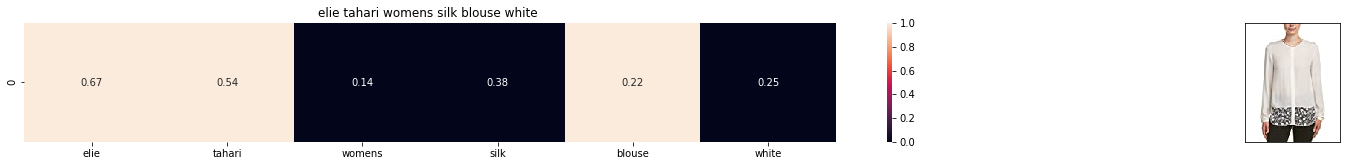

ASIN : B0758ZBV4G
BRAND : Elie Tahari
Eucliden distance from the given image : 0.930818338718771


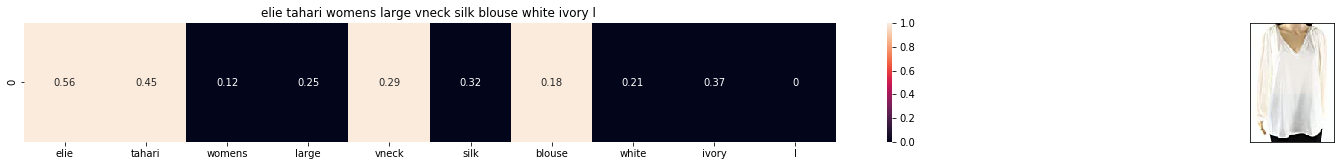

ASIN : B0758L371D
BRAND : Elie Tahari
Eucliden distance from the given image : 0.9469671521902451


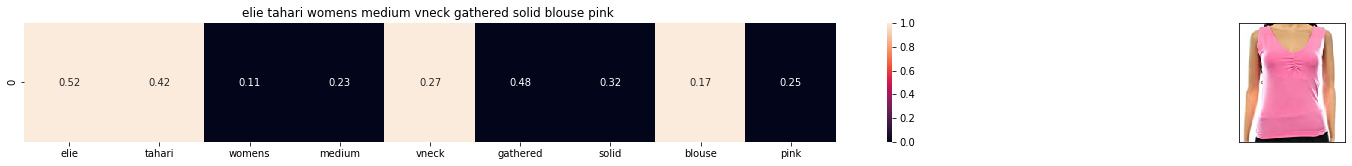

ASIN : B072VH8MKT
BRAND : Elie Tahari
Eucliden distance from the given image : 0.9917066516089337


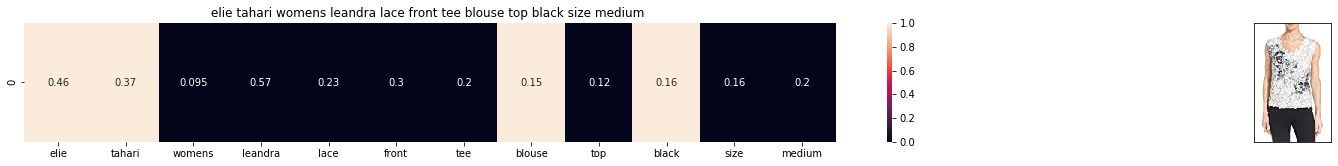

ASIN : B072HMB95W
BRAND : Elie Tahari
Eucliden distance from the given image : 1.0506076854072617


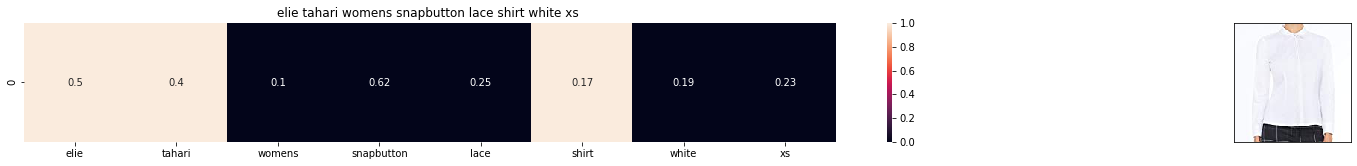

ASIN : B06X8YS632
BRAND : Elie Tahari
Eucliden distance from the given image : 1.0665664113528144


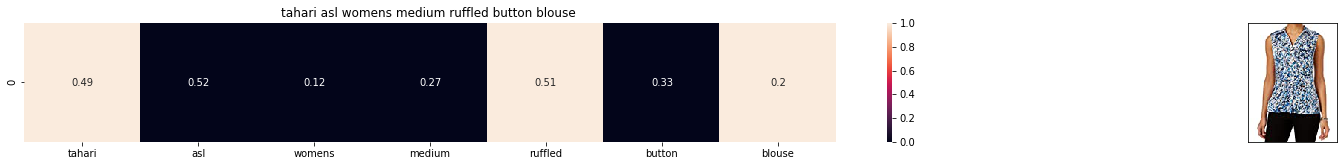

ASIN : B0727R3ZK8
BRAND : Tahari ASL
Eucliden distance from the given image : 1.070933413046932


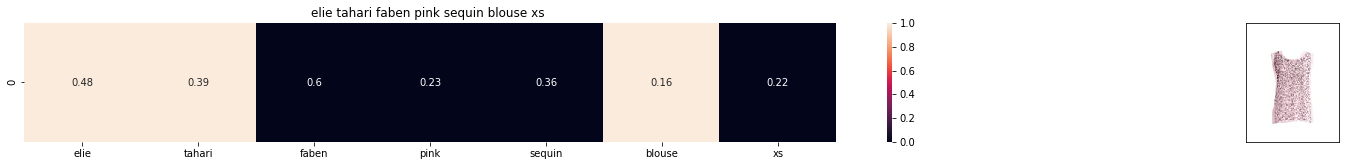

ASIN : B074VCVG5V
BRAND : Elie Tahari
Eucliden distance from the given image : 1.0854544619900401


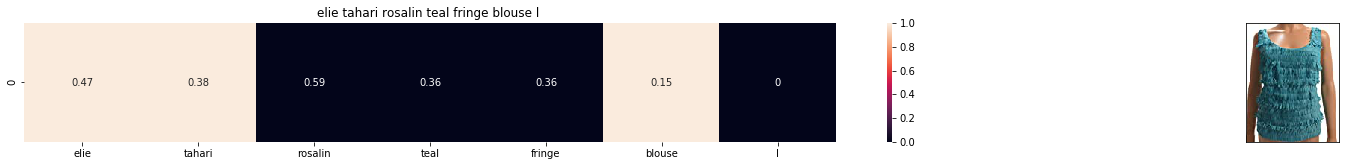

ASIN : B0751J7MJ5
BRAND : Elie Tahari
Eucliden distance from the given image : 1.0920291629067291


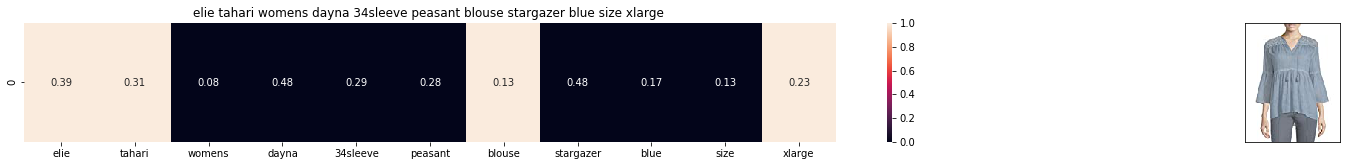

ASIN : B07258KQPD
BRAND : Elie Tahari
Eucliden distance from the given image : 1.0977009126384474


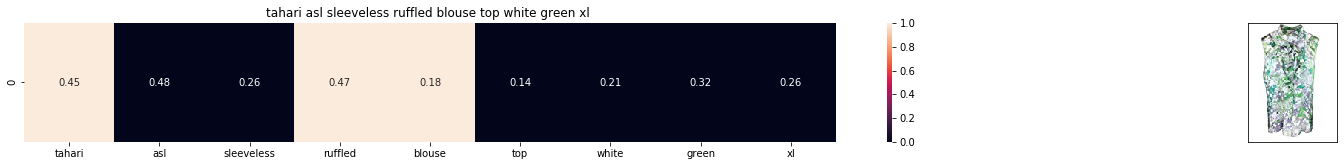

ASIN : B07196K8ZK
BRAND : Tahari ASL
Eucliden distance from the given image : 1.0978263376268496


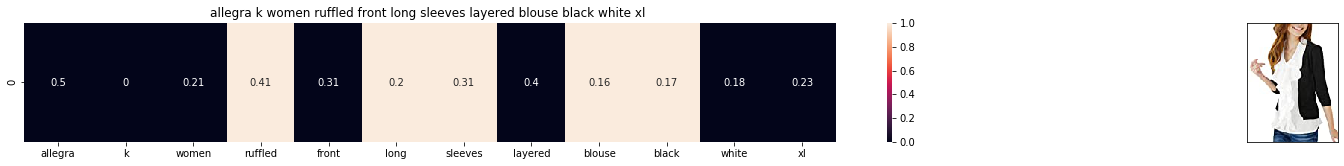

ASIN : B00E1LCYZI
BRAND : Allegra K
Eucliden distance from the given image : 1.109367974483852


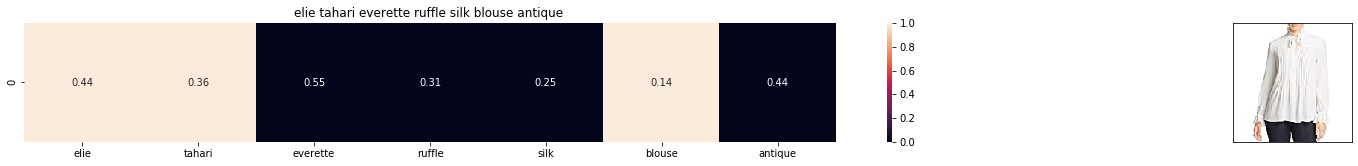

ASIN : B06XQS7B2H
BRAND : Elie Tahari
Eucliden distance from the given image : 1.115849428800062


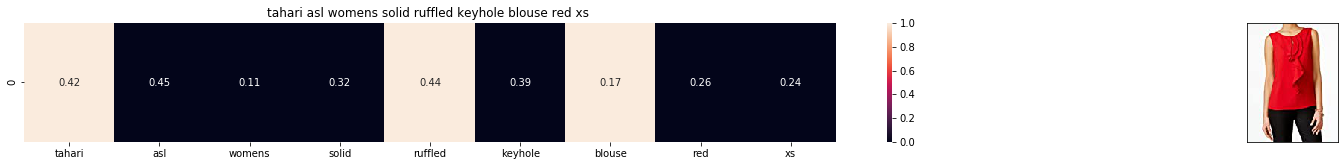

ASIN : B073DRMT4F
BRAND : Tahari ASL
Eucliden distance from the given image : 1.1230889703967402


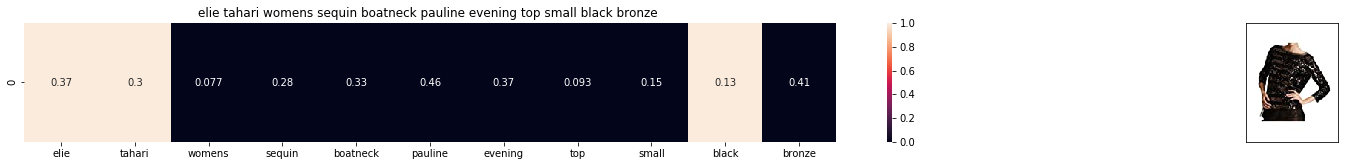

ASIN : B005E2L4XG
BRAND : Elie Tahari
Eucliden distance from the given image : 1.1459082030786756


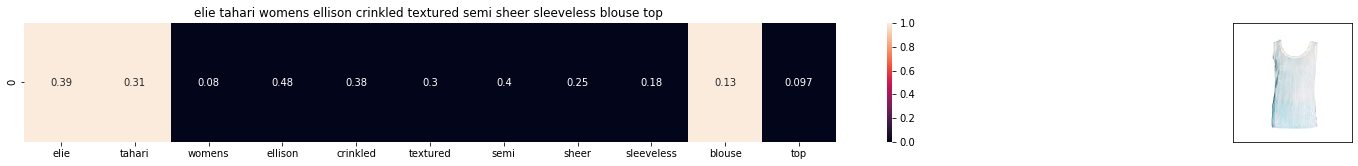

ASIN : B074VBLW5S
BRAND : Elie Tahari
Eucliden distance from the given image : 1.158176990943359


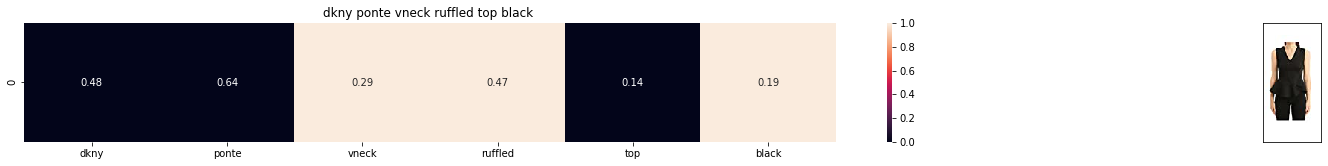

ASIN : B06XH7HQ2T
BRAND : DKNY
Eucliden distance from the given image : 1.1592903335734797


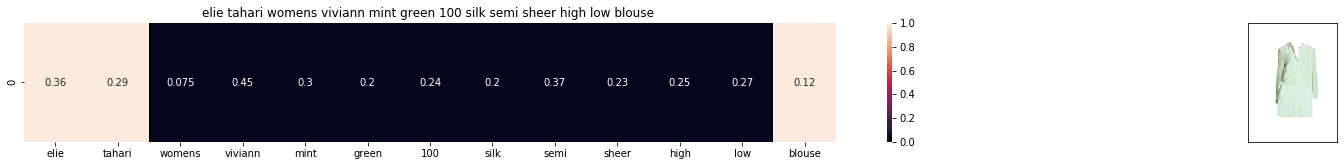

ASIN : B074VBRNX8
BRAND : Elie Tahari
Eucliden distance from the given image : 1.1758332562415978


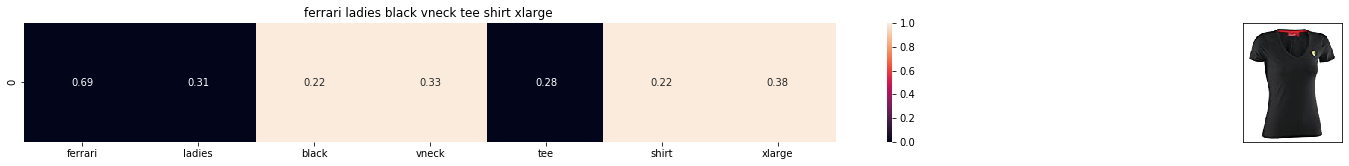

ASIN : B01EZ6XKR4
BRAND : Ferrari
Eucliden distance from the given image : 1.1773106599940455


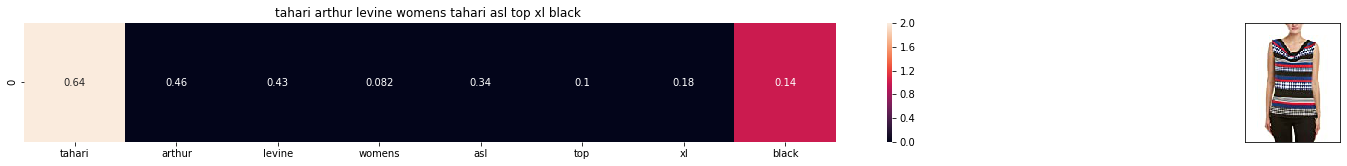

ASIN : B06X1BSY2V
BRAND : Tahari by Arthur S. Levine
Eucliden distance from the given image : 1.1849129271513121


In [53]:
def tfidf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'tfidf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)
tfidf_model(12566, 20)
# in the output heat map each value represents the tfidf values of the label word, the color represents the intersection with inputs title